In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from catboost import CatBoostClassifier, Pool
import shap
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from feature_mapping import *
from sklearn.preprocessing import StandardScaler

/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# df_5 = pd.read_csv('../casp 5/cleaned_casp5.csv')
df = pd.read_spss('../final_data/caspian-5.sav',convert_categoricals=False)

In [3]:
df.replace('', np.nan, inplace=True)
df.replace('?', np.nan, inplace=True)

In [4]:
df.loc[(df['s_122'] == 1) & df['s_121'].isna(), 's_121'] = 20
df.loc[(df['s_122'] == 2) & df['s_121'].isna(), 's_121'] = 17
df.loc[(df['s_122'] == 3) & df['s_121'].isna(), 's_121'] = 15
df.loc[(df['s_122'] == 4) & df['s_121'].isna(), 's_121'] = 10


df.drop(columns=["s_122"], inplace=True)

In [5]:
to_drop_col = []
for column in df.columns:
    null_percentage = df[column].isnull().mean()*100
    print(f"Column '{column}' has {null_percentage} null values.")
    if null_percentage>80:
        to_drop_col.append(column)
print(df.shape)
df=df.drop(to_drop_col,axis=1)
print(df.shape)
print(to_drop_col)

Column 'id2' has 0.0 null values.
Column 'University' has 0.0 null values.
Column 'region' has 0.0 null values.
Column 'cluster' has 0.0 null values.
Column 'cross' has 0.0 null values.
Column 'sex' has 0.0 null values.
Column 'birth_ye' has 0.0 null values.
Column 'sample_c' has 0.0 null values.
Column 'a_1' has 0.21454623471358078 null values.
Column 'a_2' has 0.1930916112422227 null values.
Column 'a_3' has 0.0715154115711936 null values.
Column 'a_4' has 0.11442465851390976 null values.
Column 'b_5' has 0.05721232925695488 null values.
Column 'b_6' has 0.04290924694271615 null values.
Column 'b_7' has 0.5077594221554745 null values.
Column 'b_8' has 3.1538296502896372 null values.
Column 'c_9' has 0.05721232925695488 null values.
Column 'c_10' has 0.17878852892798397 null values.
Column 'c_11' has 0.0357577057855968 null values.
Column 'c_12' has 0.07866695272831295 null values.
Column 'c_13' has 0.07866695272831295 null values.
Column 'd_14' has 0.04290924694271615 null values.
Co

In [6]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
for col in numerical_columns:
    if df[col].isna().any():  # Only process columns with missing values
        df[col] = df.groupby('age')[col].transform(
            lambda x: x.fillna(x.mean())
        )
for col in categorical_columns:
    # Fill null values with the mode of the column within each age group
    if df[col].isna().any():  # Only process columns with missing values
        df[col] = df.groupby('age')[col].transform(
            lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
        )

In [7]:
map_number = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}
col = ['n_85', 'n_86', 'n_87', 'n_88']

df[col] = df[col].applymap(lambda x: map_number.get(x, x))

n_90_map = {1:1,2:2,3:1}
df['n_90'] = df['n_90'].apply(lambda x: n_90_map.get(x, x))
df['n_93'] = 10 - df['n_93']


In [8]:
df['depression_risk']= (df['n_85']+df['n_86']+df['n_87']+df['n_88']+df['n_90']+df['n_91']+df['n_92']+df['n_93'])

<Axes: >

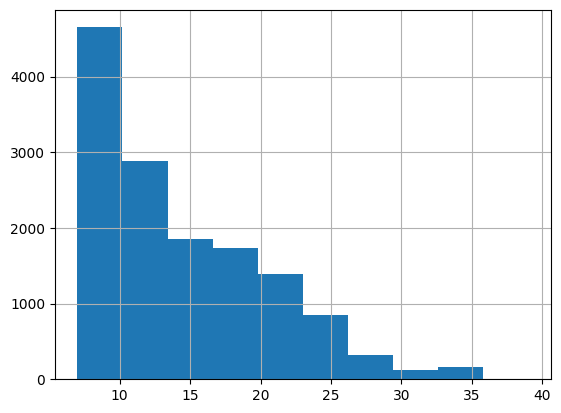

In [9]:
df['depression_risk'].hist()

In [10]:
df.drop(['n_85', 'n_86', 'n_87', 'n_88','n_90','n_91','n_92','n_93','var00001','univers0','region2','cluster2','cross2','sex2','birth_y0','sample_0'],axis=1,inplace=True)

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['depression_risk']] = scaler.fit_transform(df[['depression_risk']])

In [12]:
df['depression_risk'].isna().sum()

0

In [13]:
# Select all columns starting with "h_"
c_features = df.loc[:, df.columns.str.startswith('c_')]

# Add other specific columns (e.g., "age" and "weight")
extra_cols = ["age", "sex","s_121",'v_47','v_48','v_49','v_50','v_51']

# Ensure extra columns exist in the DataFrame to avoid KeyErrors
existing_extra_cols = [col for col in extra_cols if col in df.columns]

# Combine them
selected_features = df[c_features.columns.tolist() + existing_extra_cols]

print(selected_features)


       c_9  c_10  c_11  c_12  c_13   age  sex  s_121  v_47  v_48  v_49  v_50  \
0      1.0   1.0   1.0   1.0   1.0  12.0  0.0  20.00   1.0   3.0   1.0   3.0   
1      1.0   1.0   2.0   2.0   1.0  13.0  0.0  20.00   1.0   3.0   1.0   3.0   
2      3.0   4.0   3.0   2.0   1.0  14.0  1.0  17.00   1.0   1.0   2.0   3.0   
3      1.0   2.0   3.0   2.0   1.0  14.0  1.0  18.50   2.0   2.0   1.0   1.0   
4      2.0   2.0   1.0   3.0   2.0  15.0  1.0  17.75   1.0   2.0   1.0   3.0   
...    ...   ...   ...   ...   ...   ...  ...    ...   ...   ...   ...   ...   
13978  2.0   2.0   3.0   3.0   1.0  11.0  1.0  17.00   1.0   3.0   1.0   3.0   
13979  3.0   1.0   2.0   2.0   2.0  18.0  1.0  13.45   1.0   3.0   1.0   3.0   
13980  3.0   2.0   1.0   2.0   1.0   8.0  1.0  15.00   1.0   3.0   1.0   1.0   
13981  2.0   2.0   1.0   2.0   1.0  14.0  0.0  17.00   1.0   3.0   1.0   2.0   
13982  1.0   1.0   2.0   1.0   1.0   9.0  1.0  20.00   1.0   3.0   1.0   3.0   

       v_51  
0       3.0  
1       3.0

In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# X = df.drop(['depression_risk'],axis=1)
X = selected_features
y = df['depression_risk']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True)
scaler = MinMaxScaler()
# Fit and transform on training data, transform only on test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a RandomForest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Model Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse, r2

(0.11401394554781168, 0.6377953462055757)

In [20]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    labels = labels.reset_index(drop=True)  # Reset index to avoid KeyErrors
    pred = pd.Series(pred).reset_index(drop=True)

    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels.iloc[j] > 0 and abs(labels.iloc[i]) > labels.iloc[j]:
                total += 1
                if pred.iloc[j] > pred.iloc[i]:
                    matches += 1
                    
    return matches / total if total > 0 else 0  # Avoid division by zero



# see how well we can order people by survival
c_statistic_harrell(y_pred, y_test)

0.15635703051704017

In [15]:
X.columns

Index(['c_9', 'c_10', 'c_11', 'c_12', 'c_13', 'age', 'sex', 's_121', 'v_47',
       'v_48', 'v_49', 'v_50', 'v_51'],
      dtype='object')

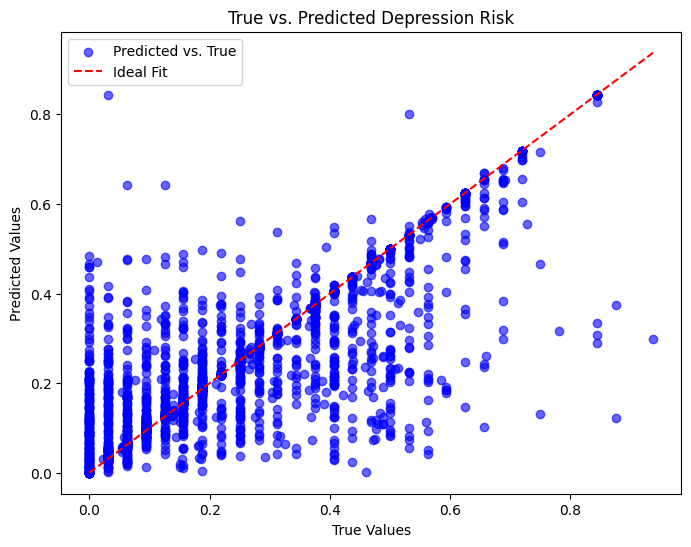

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='b', label='Predicted vs. True')

# Plot ideal line (y = x) for reference
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Depression Risk")
plt.legend()
plt.show()


In [18]:
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled, check_additivity=False)

100%|===================| 2794/2797 [02:30<00:00]        

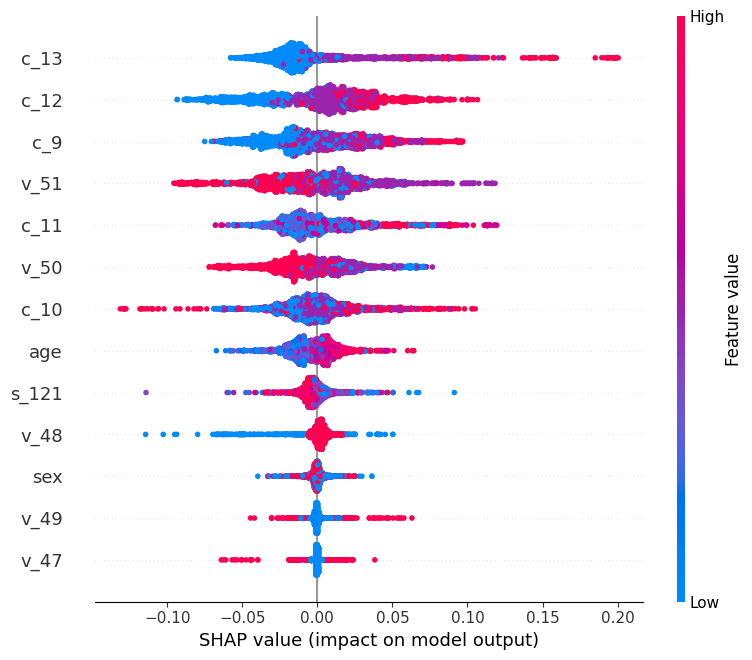

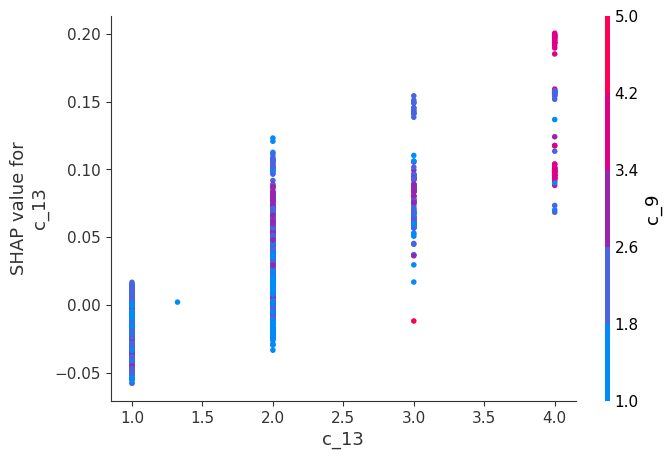

In [27]:
feature_names = X.columns  # Get feature names from original DataFrame
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)

# Dependence plot for 'Feelings about School'
shap.dependence_plot('c_13' ,shap_values.values, X_test,feature_names=feature_names)


/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/sklearn/inspection/_plot/partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


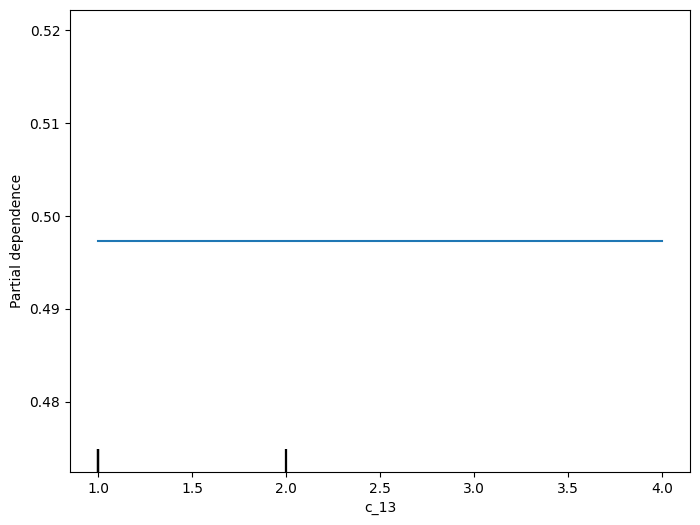

In [21]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Create partial dependence plot
fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(model, X, ['c_13'], ax=ax)
plt.show()


/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/sklearn/base.py:486: 

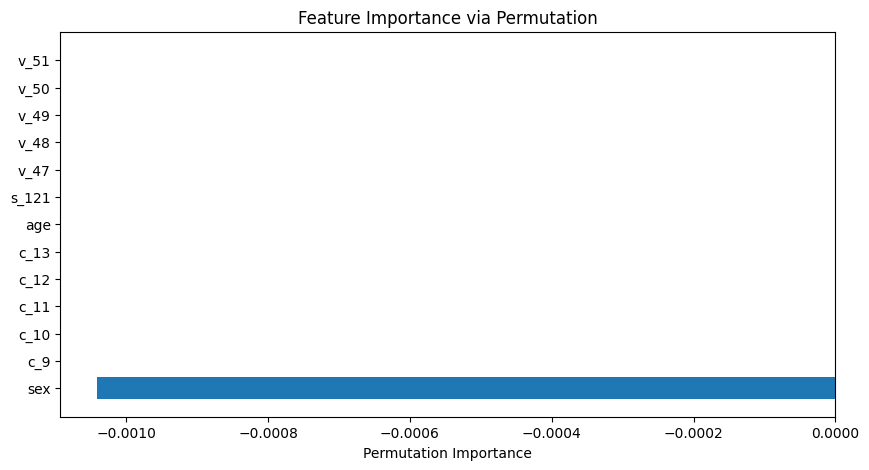

In [22]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X, y, n_repeats=10, random_state=42)

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 5))
plt.barh(np.array(feature_names)[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance via Permutation")
plt.show()


In [25]:
result.importances_mean

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.00104106,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])